In [196]:
import numpy as np
import wave as _wave
import matplotlib.pyplot as plt
import IPython.display as ipd

In [218]:
class monowave ( object ):
    
    def __init__( self, file, window_size=1024, overlap=4 ):
        wav = _wave.open(file)
        self.rate = wav.getframerate()
        self.nchannels = wav.getnchannels()
        self.sampwidth = wav.getsampwidth()
        self.nframes = wav.getnframes()
        self.data = wav.readframes(self.nframes)
        wav.close()

        self.data_length = len(self.data)
        print(self.data_length)
        
        # normalize
        if self.sampwidth == 2:
            self.data = np.frombuffer(self.data, dtype=np.int16)
            self.data = np.reshape(self.data, (len(self.data) // self.nchannels, self.nchannels))
        elif self.sampwidth == 3:
            self.data = np.frombuffer(self.data, dtype=np.uint8)
            # 24bit to 32bit
            out = np.zeros(self.data_length // 3, dtype='<i4')
            out.shape = -1, self.nchannels
            temp = out.view('uint8').reshape(-1, 4)
            columns = slice(1, None)
            temp[:, columns] = self.data.reshape(-1, 3)
            self.data = out
        elif self.sampwidth == 1:
            self.data = (self.data.astype(np.int16) - np.power(2, 7)).astype(np.int8)
            
        # monowrap
        if self.nchannels > 1:
            self.data = (self.data[:,0] + self.data[:,1]) / 4
        else:
            self.data = self.data[:,0]
            
        # discrete transform    
        
        # Hann window function coefficients
        hann = 0.5 - 0.5 * np.cos(2.0 * np.pi * (np.arange(window_size)) / window_size)

        # Hann window must have 4x overlap for good results.
        overlap = 4

        # will hold the Discrete Fourier Transform of each window. 
        DFT = []
        for left in np.arange(0, self.data.shape[0], window_size//overlap):
            right = left + window_size
            x = self.data[left:right]
            if x.shape[0] == window_size:
                y = np.fft.rfft(x * hann)[:window_size//2]
                DFT.append(y)
                
        # Normalize data and convert to dB.
        DFT = np.column_stack(DFT)
        DFT = np.absolute(DFT) * 2.0 / np.sum(hann)
        DFT = DFT / np.power(2.0, (8 * self.sampwidth - 1))
        DFT= (20.0 * np.log10(DFT)).clip(-120)
        
        self.DFT = DFT
        
        # Time domain: We have DFT.shape[1] windows, so convert to seconds by multiplying
        # by window size, dividing by sample rate, and dividing by the overlap rate.
        self.t = np.arange(0, DFT.shape[1], dtype=np.float) * window_size / self.rate / overlap
        
        # Frequency domain: There are window_size/2 frequencies represented, and we scale
        # by dividing by window size and multiplying by sample frequency.
        self.f = np.arange(0, window_size / 2, dtype=np.float) * self.rate / window_size
            
        
    def draw_audio(self):
        plt.figure(figsize=(12.0,8.0))
        plt.plot(wav.data)

    def draw_spectrogram(self):
        # Plot the spectrogram.
        plt.figure(figsize=(15,8),dpi=100)
        ax = plt.subplot(111)
        # vmin = -120, vmax 120
        plt.pcolormesh(self.t, self.f, self.DFT, vmin=-10, vmax=0, alpha=.25)

        # Set x/y limits by using the maximums from the time/frequency arrays.
        plt.xlim(0, self.t[-1])
        plt.ylim(0, self.f[-1])
        # Set axis labels.
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")

        # Show legend and set label.
        cbar = plt.colorbar()
        cbar.set_label("Intensity (dB)")

        # Display spectrogram.
        plt.show()

In [219]:
wav = monowave("080BPM_C#min_Battle_Harp.wav")

3175200


In [220]:
wav.data.shape

(529200,)

In [222]:
ipd.Audio(data=wav.data,rate=wav.rate)

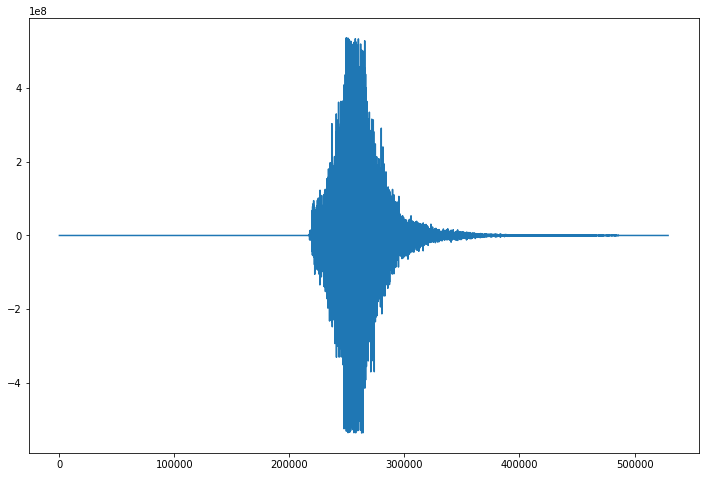

In [223]:
wav.draw_audio()

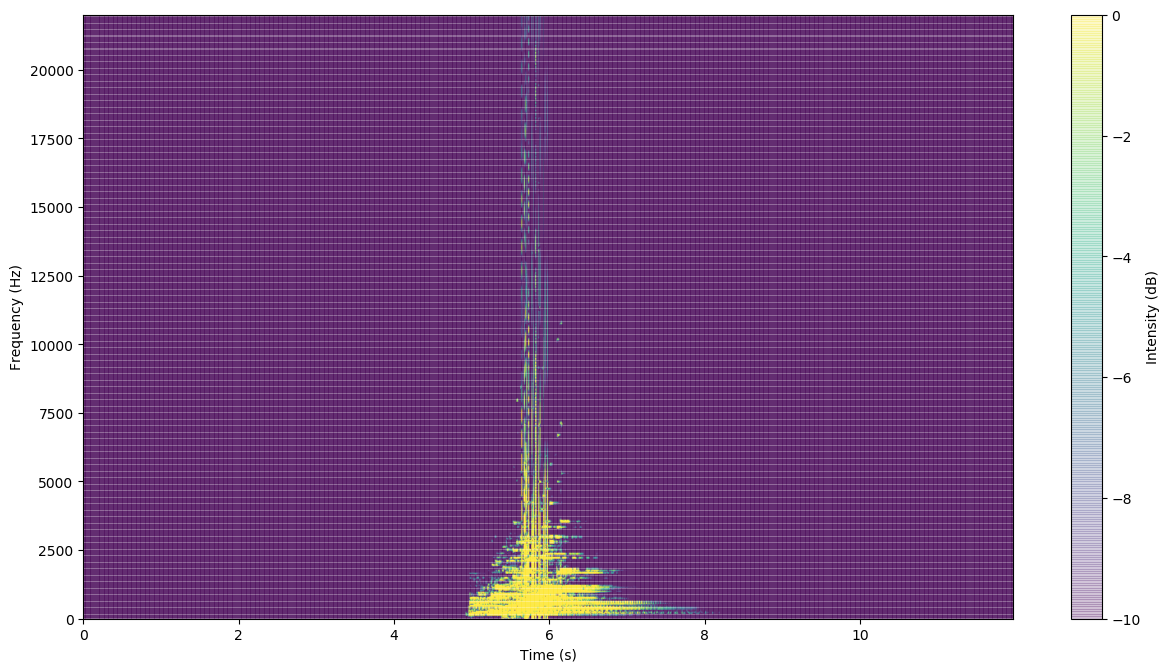

In [224]:
wav.draw_spectrogram()

In [178]:
window_size = 1024

# Hann window function coefficients
hann = 0.5 - 0.5 * np.cos(2.0 * np.pi * (np.arange(window_size)) / window_size)

# Hann window must have 4x overlap for good results.
overlap = 4

# Y will hold the DFT of each window. 
Y = []

In [179]:
for left in np.arange(230000, wav.data.shape[0], window_size//overlap):
    right = left + window_size
    x = wav.data[left:right]
    if x.shape[0] == window_size:
        y = np.fft.rfft(x * hann)[:window_size//2]
        Y.append(y)

In [180]:
# Normalize data and convert to dB.
Y = np.column_stack(Y)
Y = np.absolute(Y) * 2.0 / np.sum(hann)
Y = Y / np.power(2.0, (8 * wav.sampwidth - 1))
Y = (20.0 * np.log10(Y)).clip(-120)

In [181]:
# Time domain: We have Y.shape[1] windows, so convert to seconds by multiplying
# by window size, dividing by sample rate, and dividing by the overlap rate.
t = np.arange(0, Y.shape[1], dtype=np.float) * window_size / wav.rate / overlap

In [182]:
# Frequency domain: There are window_size/2 frequencies represented, and we scale
# by dividing by window size and multiplying by sample frequency.
f = np.arange(0, window_size / 2, dtype=np.float) * wav.rate / window_size

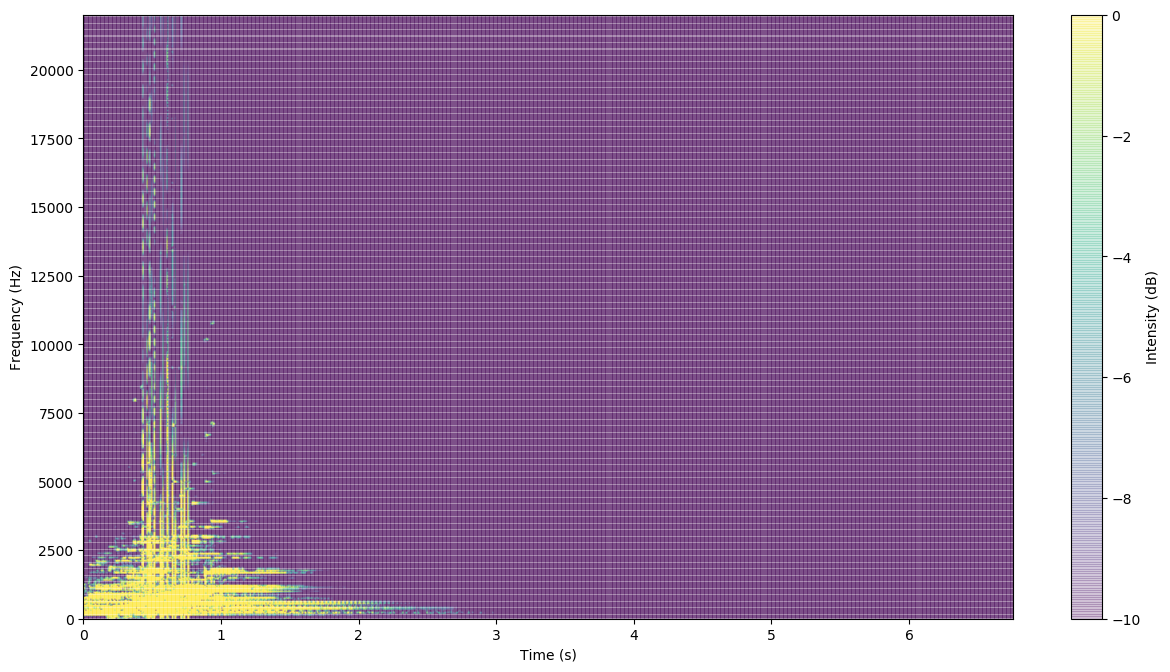

In [195]:
# Plot the spectrogram.
plt.figure(figsize=(15,8),dpi=100)
ax = plt.subplot(111)
# vmin = -120
plt.pcolormesh(t, f, Y, vmin=-10, vmax=0, alpha=.25)

# Set x/y limits by using the maximums from the time/frequency arrays.
plt.xlim(0, t[-1])
plt.ylim(0, f[-1])
# Set axis labels.
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
    
# Show legend and set label.
cbar = plt.colorbar()
cbar.set_label("Intensity (dB)")
    
# Display spectrogram.
plt.show()
    